#### Load dataframe

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder

In [64]:
RANDOM_SEED = 42
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [65]:
calls_df = pd.read_csv('features_and_spectrograms.csv')
calls_df['log_padded_spectrogram'] = calls_df['log_padded_spectrogram'].apply(lambda x: np.array(json.loads(x)))

In [66]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_ID                7300 non-null   object 
 1   clip_ID                 7300 non-null   object 
 2   goose_ID                7300 non-null   object 
 3   call_type               7300 non-null   object 
 4   waveform                7300 non-null   object 
 5   sr                      7300 non-null   int64  
 6   filepath                7300 non-null   object 
 7   lfccs                   7300 non-null   object 
 8   peak                    7300 non-null   float64
 9   duration                7300 non-null   float64
 10  normalized_log_length   7300 non-null   float64
 11  log_target_duration     7300 non-null   float64
 12  log_padded_spectrogram  7300 non-null   object 
 13  log_padded_lfccs        7300 non-null   object 
 14  f0mean                  6484 non-null   

In [67]:
print(len(calls_df[calls_df.isna().any(axis=1)]))
calls_df = calls_df.dropna()
calls_df = calls_df[["track_ID", "clip_ID", "goose_ID", "call_type", "log_padded_spectrogram"]]
calls_df.info()

816
<class 'pandas.core.frame.DataFrame'>
Index: 6484 entries, 0 to 7299
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   track_ID                6484 non-null   object
 1   clip_ID                 6484 non-null   object
 2   goose_ID                6484 non-null   object
 3   call_type               6484 non-null   object
 4   log_padded_spectrogram  6484 non-null   object
dtypes: object(5)
memory usage: 303.9+ KB


In [68]:
le = LabelEncoder()
le.fit(calls_df["call_type"])
calls_df["encoded_call_type"] = le.transform(calls_df["call_type"])

### Variational Autoencoder

In [69]:
learning_rate = 1e-3
batch_size = 256 # very unbalanced dataset so choosing a bigger batch size - TODO balance
epochs = 60
retrain = True

In [70]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


#### Create data loader

In [71]:
calls_df.iloc[0]["log_padded_spectrogram"].shape

(44, 170)

In [81]:
class SoundDS(Dataset):
    # Custom data loader 
    def __init__(self, calls_df):
        self.df = calls_df
                
    # of items in dataset
    def __len__(self):
        return len(self.df)    
    
    # Get item through index
    def __getitem__(self, idx):
        spectrogram = torch.from_numpy(self.df.iloc[idx]["log_padded_spectrogram"]).to(torch.float32).to(device)
        spectrogram = spectrogram[np.newaxis, ...]
        return spectrogram, self.df.iloc[idx]["encoded_call_type"]

In [82]:
ds = SoundDS(calls_df)

# Random split for train:val - 80:20
num_items = len(ds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(ds, [num_train, num_val])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [83]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape, type: {train_labels.size()}")

input_size=train_features.size()[1:]
print(input_size[1], input_size[2])

Feature batch shape: torch.Size([256, 1, 44, 170])
Labels batch shape, type: torch.Size([256])
44 170


#### Define architecture

In [46]:
class ConvolutionalAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            # input shape (n, 1, 44, 170)
            torch.nn.Conv2d(1, 8, (4,4), (2,2), (1,2)), # output shape (n, 8, 22, 86)
            torch.nn.BatchNorm2d(8),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(8, 4, (4,4), (2,2), (1,1)), # output shape (n, 4, 11, 43)
            torch.nn.BatchNorm2d(4),
            torch.nn.LeakyReLU(),
            torch.nn.Flatten(), # output shape (n, 1280)
            torch.nn.Linear(1892, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 128),
        )

        # latent mean and variance 
        self.mean_layer = torch.nn.Linear(128, 2)
        self.logvar_layer = torch.nn.Linear(128, 2)
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 128),
            torch.nn.Linear(128, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 1892),
            torch.nn.Unflatten(1, (4, 11, 43)),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(4),
            torch.nn.ConvTranspose2d(4, 8, (4,4), (2,2), (1,1)),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(8),
            torch.nn.ConvTranspose2d(8, 1, (4,4), (2,2), (1,2)),
            torch.nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def decode(self, x):
        return self.decoder(x)
    
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [47]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = torch.nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [48]:
model = ConvolutionalAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#loss_fn = torch.nn.L1Loss()
print(model)

ConvolutionalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1892, out_features=512, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=128, bias=True)
  )
  (mean_layer): Linear(in_features=128, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=128, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Line

In [17]:
class EarlyStopper:
    # written by https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [49]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_dl):

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=epochs, device=device)

	Epoch 1 	Average Loss:  5716.945111083985
	Epoch 2 	Average Loss:  5058.623864746094
	Epoch 3 	Average Loss:  4572.573999023438
	Epoch 4 	Average Loss:  4076.6557434082033
	Epoch 5 	Average Loss:  3577.964938354492
	Epoch 6 	Average Loss:  3099.068469238281
	Epoch 7 	Average Loss:  2668.090512084961
	Epoch 8 	Average Loss:  2309.4627075195312
	Epoch 9 	Average Loss:  2032.553921508789
	Epoch 10 	Average Loss:  1825.0949874877929
	Epoch 11 	Average Loss:  1678.5915405273438
	Epoch 12 	Average Loss:  1573.4331069946288
	Epoch 13 	Average Loss:  1499.1247024536133
	Epoch 14 	Average Loss:  1445.8086868286132
	Epoch 15 	Average Loss:  1406.9461380004882
	Epoch 16 	Average Loss:  1375.1038757324218
	Epoch 17 	Average Loss:  1358.479914855957
	Epoch 18 	Average Loss:  1337.8428466796875
	Epoch 19 	Average Loss:  1323.2069396972656
	Epoch 20 	Average Loss:  1311.0128021240234
	Epoch 21 	Average Loss:  1304.5135528564454
	Epoch 22 	Average Loss:  1297.2100372314453
	Epoch 23 	Average Loss:  1

6367662.984375

Feature batch shape: torch.Size([256, 1, 44, 170])
Labels batch shape, type: torch.Size([256])


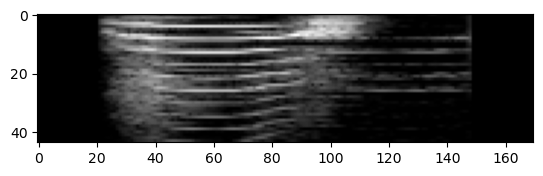

Label: 2


In [ ]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape, type: {train_labels.size()}")
call = train_features[0]
img = call.cpu().squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

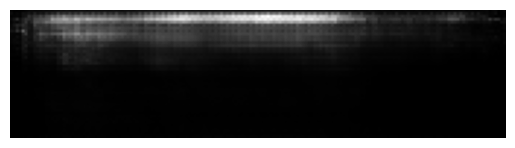

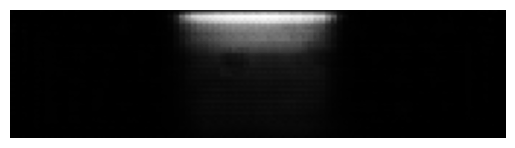

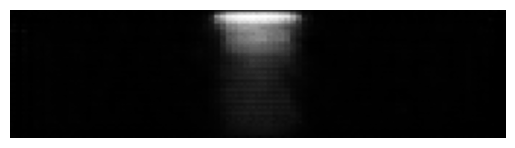

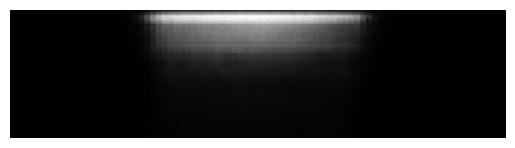

(None, None, None, None)

In [ ]:
def generate_call(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    call = x_decoded.detach().cpu().reshape(44, 170)
    plt.imshow(call, cmap='gray')
    plt.axis('off')
    plt.show()

generate_call(0.0, 1.0), generate_call(.5, .5), generate_call(1.0, 1.0)

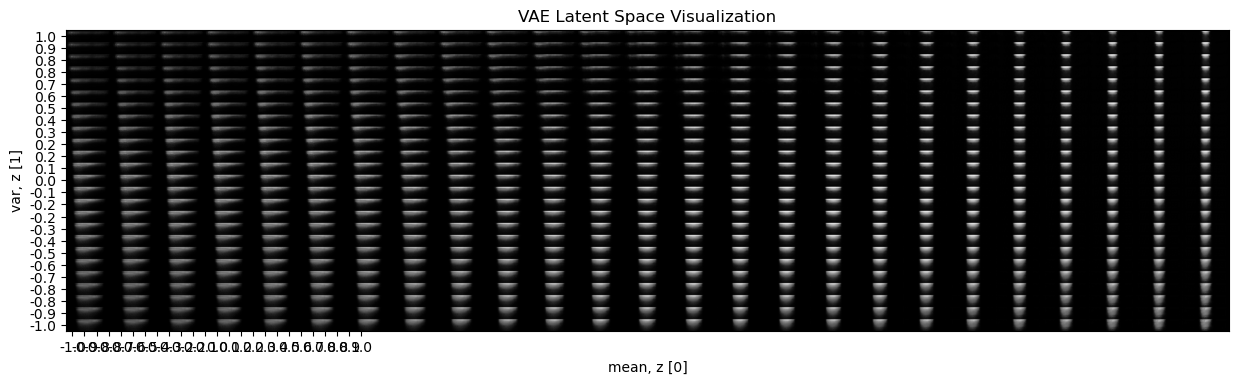

In [91]:
def plot_latent_space(model, scale=1.0, n=25, call_size=(44, 170), figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((call_size[0] * n, call_size[1] * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(call_size, call_size)
            figure[i * call_size[0] : (i + 1) * call_size[0], j * call_size[1] : (j + 1) * call_size[1],] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = call_size[0] // 2
    end_range = n * call_size[0] + start_range
    pixel_range = np.arange(start_range, end_range, call_size[0])
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)